<a href="https://githubtocolab.com/BioWar/Satellite-Image-Segmentation-using-Deep-Learning-for-Deforestation-Detection/blob/main/Model_Training_TPU_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Model training using distributed TPU strategy


## Preparing the environment

### Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,\
                                    MaxPool2D, UpSampling2D, concatenate,\
                                    Input, Conv2DTranspose, MaxPooling2D,\
                                    Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow.keras as K

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda 
import pathlib
import datetime
import copy
import PIL
import sys
import random
import os
from matplotlib import colors

from tensorflow.keras import backend as K
from scipy.ndimage import distance_transform_edt as distance

# random.seed(42)
# tf.random.set_seed(42)
# np.random.seed(42)

### Configure TPU

In [ ]:
print("TensorFlow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow version 2.4.1


In [ ]:
try:
    tpu_address = "grpc://" + os.environ['COLAB_TPU_ADDR']
    print(f'[INFO] TPU address: {tpu_address}.')
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('[INFO] TPU strategy created and initialized successfully.')
except ValueError:
  print('[ERROR] TPU failed to initialize.')

[INFO] TPU address: grpc://10.50.127.34:8470.
INFO:tensorflow:Initializing the TPU system: grpc://10.50.127.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.50.127.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


[INFO] TPU strategy created and initialized successfully.


### Connect GoogleDrive

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Connect Google Cloud Storage

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'sustained-valor-300008'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://deforestation_kpi/


## Defining model related code

### Loss functions and Metrics


In [ ]:
class IOU(tf.keras.metrics.Metric):

  def __init__(self, name, C, **kwargs):
    super(IOU, self).__init__(name=name, **kwargs)
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.C = C

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    value = 0
    for index in range(self.C):
      intersection = tf.math.reduce_sum(tf.math.multiply(y_true[..., index], y_pred[..., index]))
      union = tf.math.reduce_sum(y_true[..., index]) + tf.math.reduce_sum(y_pred[..., index]) - intersection
      value += tf.math.reduce_sum((intersection + 1e-16) / (union + 1e-16))
    self.iou.assign_add(value / self.C)

  def reset_states(self):
    for s in self.variables:
      s.assign(tf.zeros(shape=s.shape))

  def result(self):
    return self.iou

In [ ]:
class F1Score(tf.keras.metrics.Metric):

  def __init__(self, name, C, **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.f1score = self.add_weight(name='f1score', initializer='zeros')
    self.C = C

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    value = 0
    for index in range(self.C):
      intersection = tf.math.reduce_sum(tf.math.multiply(y_true[..., index], y_pred[..., index]))
      union = tf.math.reduce_sum(y_true[..., index]) + tf.math.reduce_sum(y_pred[..., index])
      value += tf.math.reduce_sum((2. * intersection + 1e-16) / (union + 1e-16))
    self.f1score.assign_add(value / self.C)

  def reset_states(self):
    for s in self.variables:
      s.assign(tf.zeros(shape=s.shape))

  def result(self):
    return self.f1score

In [ ]:
class BorderLoss(tf.keras.losses.Loss):
  """
  https://arxiv.org/pdf/1812.07032.pdf
  https://github.com/LIVIAETS/boundary-loss/blob/master/keras_loss.py
  """
  def __init__(self, C : "Num of classes, third dimenstion", 
               name="border_loss_function", reduction=tf.keras.losses.Reduction.NONE):
    super().__init__(reduction=reduction, name=name)
    self.C = C

  def calc_dist_map(self, seg):
      res = np.zeros_like(seg)
      posmask = seg.astype(np.bool)

      if posmask.any():
          negmask = ~posmask
          res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

      return res

  def calc_dist_map_batch(self, y_true):
      y_true_numpy = y_true.numpy()
      return np.array([self.calc_dist_map(y)
                      for y in y_true_numpy]).astype(np.float32)

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    result_list = []
    for index in range(self.C):
      y_true_dist_map = self.calc_dist_map_batch(y_true[..., index])
      result = y_pred[..., index] * y_true_dist_map
      result_list.append(result)
    return tf.stack(result)

In [ ]:
class HybridLoss(tf.keras.losses.Loss):
  def __init__(self, _lambda_, _alpha, _beta, smooth=1e-16, C=3, weights=[0.5, 2.0, 0.5], 
               reduction=tf.keras.losses.Reduction.NONE,
               name='tversky_loss_function'):
    super().__init__(reduction=reduction, name=name)
    self._lambda_ = _lambda_
    self._alpha = _alpha
    self._beta = _beta
    self.smooth = smooth
    self.C = C
    self.weights = weights

  def tversky_loss(self, y_true, y_pred):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    tversky = []
    for index in range(self.C): # Class order: Forest, Deforest., Other.

        TP = tf.reduce_sum(tf.math.multiply(y_pred[..., index], y_true[..., index]), axis=1)
        FP = tf.reduce_sum(tf.math.multiply(y_pred[..., index], 1-y_true[..., index]), axis=1)
        FN = tf.reduce_sum(tf.math.multiply(1-y_pred[..., index], y_true[..., index]), axis=1)
       
        tversky_i = (TP + self.smooth) / (TP + self._alpha * FP + self._beta * FN + self.smooth)  
        tversky.append(tversky_i * self.weights[index])
    return self.C - tf.stack(tversky)

  def dice_coef_multilabel(self, y_true, y_pred):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    dice = []
    for index in range(self.C):
      intersection = 2 * tf.reduce_sum(tf.math.multiply(y_pred[..., index], y_true[..., index]), axis=1)+ self.smooth
      denominator = tf.reduce_sum(tf.math.square(y_pred[..., index]) + tf.math.square(y_true[..., index]), axis=1)+ self.smooth
      dice_i = intersection / denominator 
      dice.append(- dice_i)
    return self.C + tf.stack(dice)

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    tversky = self.tversky_loss(y_true, y_pred)
    dice = self.dice_coef_multilabel(y_true, y_pred)   
    result = tversky + self._lambda_ * dice
    #result = tf.reduce_sum(result)
    return result

### Create Dataset From TFRecord file

In [ ]:
#@title Dataset creation
#@markdown On TPU in Keras, this is the per-core batch size. The global batch size is 8x this.
BATCH_SIZE = "8" #@param [2, 4, 8, 16, 32, 64]
BATCH_SIZE = int(BATCH_SIZE)

VALIDATION_SPLIT = 0.2

#@markdown Pattern which will be used to retrieve all tfrecords files:

#@markdown `GCS_PATTERN = "gs://deforestation_kpi/tfrecords_part_*.tfrec"`
GCS_PATTERN = "gs://deforestation_kpi/tfrecords_v2_part_*.tfrec" #@param {type:"string"}

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
print(f"Available {len(filenames)} files.")
for i in filenames[:5]:
  print(i)
print()
#random.shuffle(filenames)

split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
print(f"Validation filename: {validation_filenames}")
print(f"Training filename: {training_filenames}")
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Available 14 files.
gs://deforestation_kpi/tfrecords_v2_part_1.tfrec
gs://deforestation_kpi/tfrecords_v2_part_10.tfrec
gs://deforestation_kpi/tfrecords_v2_part_11.tfrec
gs://deforestation_kpi/tfrecords_v2_part_12.tfrec
gs://deforestation_kpi/tfrecords_v2_part_13.tfrec

Pattern matches 14 data files. Splitting dataset into 12 training files and 2 validation files
Validation filename: ['gs://deforestation_kpi/tfrecords_v2_part_1.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_10.tfrec']
Training filename: ['gs://deforestation_kpi/tfrecords_v2_part_11.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_12.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_13.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_14.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_2.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_3.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_4.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_5.tfrec', 'gs://deforestation_kpi/tfrecords_v2_part_6.tfrec', 'gs://deforestat

In [ ]:
def get_example(dataset_path, image_num):
  raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
  # Create a dictionary describing the features.
  image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
  }

  def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
  for image_features in parsed_image_dataset:
    if image_num != 0:
      image_raw = image_features['image'].numpy()
      mask_raw = image_features['mask'].numpy()
      image_num -= 1
    else:
      break
  image = tf.image.decode_png(image_raw, channels=3)
  image = tf.image.resize(image, [512, 512])
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  mask = tf.io.decode_raw(mask_raw, out_type="float")
  mask = tf.reshape(mask, [512, 512, 3])
  mask = tf.cast(mask, tf.float32)
  return image, mask

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, features)
    image = example['image']
    mask = example['mask']
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    mask = tf.io.decode_raw(mask, out_type="float")
    mask = tf.reshape(mask, [512, 512, 3])
    mask = tf.cast(mask, tf.float32)
    return image, mask

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=False) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

def get_training_dataset():
  dataset = get_batched_dataset(training_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

def get_validation_dataset():
  dataset = get_batched_dataset(validation_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    cmap = colors.ListedColormap(['green', 'blue', 'red'])

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap=cmap, interpolation='nearest')
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
    prediction = model.predict(sample_image[tf.newaxis, ...])[0]
    # prediction_class1 = np.copy(prediction[..., 0]) # Forest
    # prediction_class2 = np.copy(prediction[..., 1]) # Deforest
    # prediction[..., 0] = prediction_class2 # RED - Deforest
    # prediction[..., 1] = prediction_class1 # GREEN - Forest
    display([sample_image,
             sample_mask,
             prediction
            ])

### Model Building


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, sublayers=2):
    '''In case batchnorm=False "if" statement will be skipped and in amount of "sublayers" convolutional layers will be created.'''
    for idx in range(sublayers):
        conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                   kernel_initializer="he_normal", padding="same")(input_tensor if idx==0 else conv)
        if batchnorm:
            normalized = BatchNormalization()(conv)
        conv = Activation("relu")(conv) # normalized to conv
    return conv

def conv2d_transpose_block(input_tensor, concatenate_tensor, n_filters, kernel_size=3, strides=2, transpose=False):
    if transpose:
        conv = Conv2DTranspose(n_filters, (kernel_size, kernel_size),
                               strides=(strides, strides), padding='same')(input_tensor)
    else:
        conv = Conv2D(n_filters, (kernel_size, kernel_size), activation = 'relu', padding = 'same',
                      kernel_initializer = 'he_normal')(UpSampling2D(size=(kernel_size, kernel_size))(input_tensor))
    conv = Activation("relu")(conv)
    concatenation = concatenate([conv, concatenate_tensor])
    return concatenation

def build_unet(input_shape=(512, 512, 3), filters=[16, 32, 64, 128, 256], batchnorm=True, transpose=False, dropout_flag=False):  # dropout_rate=0.2
    
    conv_dict = dict()
    inputs = Input(input_shape)
    dropout_rate = 0.5
    
    for idx, n_filters in enumerate(filters[:-1]):
        conv = conv2d_block(inputs if n_filters==filters[0] else max_pool, # Change max_pool to dropout
                            n_filters=n_filters, kernel_size=3,
                            batchnorm=batchnorm)
        max_pool = MaxPooling2D((2, 2))(conv)
        # Commented dropout
#         if idx > 1 and dropout_flag:
#             print('[INFO] Dropout down')
#             dropout = Dropout(dropout_rate)(max_pool)
#         else:
#             print('[INFO] Dropout down skip')
#             dropout = max_pool
#         print(f'[INFO] Conv block {idx} created.')
        # Save layer
        conv_dict[f"conv2d_{idx+1}"] = conv
        
    # Change max_pool to dropout
    conv_middle = conv2d_block(max_pool, n_filters=filters[-1], kernel_size=3, batchnorm=batchnorm)
        
    for idx, n_filters in enumerate(reversed(filters[:-1])):
        concatenation = conv2d_transpose_block(conv_middle if idx==0 else conv,
                                               conv_dict[f"conv2d_{len(conv_dict) - idx}"],
                                               n_filters, kernel_size=2, strides=2, transpose=transpose) # kernel_size=2, like in previous
        # Commented Dropout
#         if idx < len(filters) - 3 and dropout_flag:
#             print('[INFO] Dropout up')
#             dropout = Dropout(dropout_rate)(concatenation)
#         else:
#             print('[INFO] Dropout up skip')
#             dropout = concatenation
        conv = conv2d_block(concatenation, n_filters=n_filters, kernel_size=3, # Change concatenation to Dropout
#                             batchnorm = batchnorm if idx not in [len(conv_dict), len(conv_dict) - 1] else False)
                              batchnorm = batchnorm)
        print(f'[INFO] UpConv block {idx} created.')
    outputs = Conv2D(3, (1, 1), activation='softmax')(conv)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def make_unet_experimental():
  input_size = (512, 512,3)
  inputs = Input(input_size)
      
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  up2_1  = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv2))
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  up3_1  = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv3))
  up3_2  = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up3_1))
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  up4_1  = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv4))
  up4_2  = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up4_1))
  up4_3  = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up4_2))
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  up5_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv5))
  up5_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_1))
  up5_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_2))
  up5_4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_3))

  up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
  merge6 = concatenate([conv4, up6, up5_1], axis = 3)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3, up7, up5_2, up4_1], axis = 3)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2, up8, up5_3, up4_2, up3_1], axis = 3)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1, up9, up5_4, up4_3, up3_2, up2_1], axis = 3)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  conv10 = Conv2D(3, 1, activation = 'softmax')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

## Model Training

### Custom Training loop

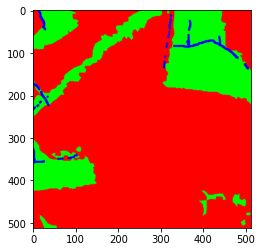

1e-05
Model name: model_tpu_1024_8_v6_u1
Path to the model: /content/gdrive/MyDrive/Models/TPU/model_tpu_1024_8_v6/U1_E:0101-F1:0.4799-IOU:0.4331.h5
Path to csv file: /content/gdrive/MyDrive/Metrics/model_tpu_1024_8_v6/results_model_tpu_1024_8_v6.csv


In [ ]:
#@title Model Training
#@markdown In this cell you could choose options such as:
#@markdown 1. **Amount of filters** in model (you choose the amount in the bottleneck and this number will be propagated to all the model with regard of the U-Net architecture);
#@markdown 2. **Model version** (Model name contains its version of architecture, and number of updates of this version. By default update equals 1)
#@markdown 3. **Path of model weights to load** (Path to saved weights, in case you want to continue training of the previous model. Empty field will create new model with randomly initialized weights);
#@markdown 4. **Sample image** (Sample image is used in the visualization callback to track model's performance during training, on the sample from dev dataset);
#@markdown 5. **Learning rate** (In case of imbalanced dataset the LR must be in range 1e-7 to 1e-5);
#@markdown 6. **Number of epochs** (Number of epochs for model training);
#@markdown 7. **Checkpoint frequency in epochs** (How often to save the model. Warning check free space on Google Drive before setting this option too low);
#@markdown 8. **Update or DELETE csv log file** (True: file will be appended and previous data will be save. False: file will be rewritten with new data);
final_filters = "1024" #@param [512, 1024, 2048]
final_filters = int(final_filters)
model_version = "v6" #@param ["v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8", "v9", "v10"]
model_name = f"model_tpu_{final_filters}_{BATCH_SIZE}_{model_version}_u1"
update = "U2" #@param ["U1", "U2", "U3", "U4", "U5", "U6", "U7", "U8", "U9", "U10"]
# path_to_load = "/content/gdrive/MyDrive/Models/TPU/model_tpu_2048_16_v4/E:0601-F1:0.6801-IOU:0.6190.h5"
path_to_load = "/content/gdrive/MyDrive/Models/TPU/model_tpu_1024_8_v6/U1_E:0101-F1:0.4799-IOU:0.4331.h5" #@param {type:"string"}
path_to_csv  = f"/content/gdrive/MyDrive/Metrics/{model_name[:-3]}/results_{model_name[:-3]}.csv"
image_number = 7 #@param {type:"slider", min:1, max:20, step:1}
image_number = int(image_number)
sample_image, sample_mask = get_example(validation_filenames[0], 2)
plt.imshow(sample_mask)
plt.show()
learning_rate = "1e-5" #@param ["1e-5", "5e-6", "1e-6", "3e-7", "1e-7"]
learning_rate = float(learning_rate)
print(learning_rate)
EPOCHS = 301 #@param {type:"integer"}
save_freq =  300#@param {type:"integer"}
append_csv = True #@param {type:"boolean"}

if not os.path.isdir(os.path.dirname(path_to_csv)):
  os.makedirs(os.path.dirname(path_to_csv))
else:
  pass

with strategy.scope():

  # Model loading or creation of the new one
  # if not path_to_load:
  #   print("Creating new model")
  #   model = build_unet(input_shape=(512, 512, 3),
  #                    filters=[2 ** i for i in range(5, int(np.log2(final_filters) + 1))], # Amount of filters in U-Net arch.
  #                    batchnorm=False, transpose=False, dropout_flag=False)
  # else:
  #   model = build_unet(input_shape=(512, 512, 3),
  #                    filters=[2 ** i for i in range(5, int(np.log2(final_filters) + 1))], # Amount of filters in U-Net arch.
  #                    batchnorm=False, transpose=False, dropout_flag=False)
  #   print("Loading model")

  # Experimental model U-Net, delete before run
  model = make_unet_experimental()
  model.load_weights(path_to_load)
  
  # Loss functi on
  loss_object = HybridLoss(_lambda_=1, _alpha=0.5, _beta=0.5, weights=[0.4, 2.2, 0.4], reduction=tf.keras.losses.Reduction.NONE)
  # loss_object = BorderLoss()
  
  def compute_loss(y_true, y_pred):
    per_example_loss = loss_object(y_true, y_pred)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE * strategy.num_replicas_in_sync)

  # Metrics
  train_iou = IOU(name="train_IoU", C=3)
  train_f1score = F1Score(name="train_f1score", C=3)
  test_iou = IOU(name="test_IoU", C=3)
  test_f1score = F1Score(name="train_f1score", C=3)

  # Optimizer
  # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # Low learning rate, for high dataset imbalance
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')

  @tf.function
  def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    print(per_replica_losses)
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

  @tf.function
  def distributed_test_step(dataset_inputs):
    strategy.run(test_step, args=(dataset_inputs,))

  def train_step(inputs):
    images, masks = inputs
    
    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = compute_loss(masks, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_iou.update_state(masks, predictions)
    train_f1score.update_state(masks, predictions)

    return loss

  def test_step(inputs):
    images, masks = inputs

    predictions = model(images)
    loss = loss_object(masks, predictions)

    test_iou.update_state(masks, predictions)
    test_f1score.update_state(masks, predictions)

# model.summary()
print(f"Model name: {model_name}")
print(f"Path to the model: {path_to_load}")
print(f"Path to csv file: {path_to_csv}")

In [ ]:
# model.summary()

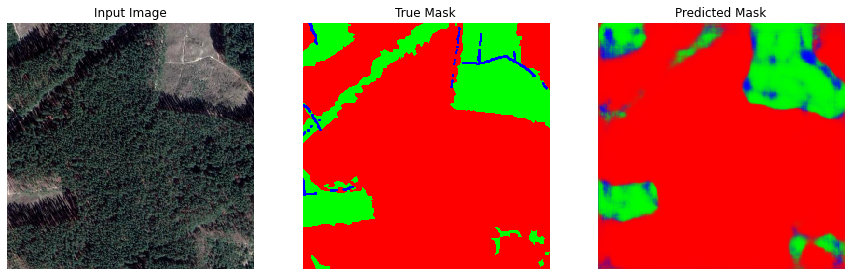

Epoch 8, Loss Hybrid: 1.86121, Train IoU: 0.4290, Train F1_Score 0.4863, Test IoU: 0.4405, Test F1_Score 0.4891


In [ ]:
checkpoint_dir = f"/content/gdrive/MyDrive/Models/TPU/{model_name[:-3]}/"
pathlib.Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
checkpoint_filepath_template = checkpoint_dir + update + "_E:{epoch:04d}-F1:{test_f1score:.4f}-IOU:{test_iou:.4f}.h5"

# Callbacks
csv_log = CSVLogger(path_to_csv, append=append_csv)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_template,
    save_weights_only=True,
    monitor='train_f1score',
    mode='max',
    save_best_only=False)

freq_counter = 0

csv_log.set_model(model=model)
model_checkpoint_callback.set_model(model=model)
csv_log.on_train_begin()
model_checkpoint_callback.on_train_begin()

with strategy.scope():
  for epoch in range(EPOCHS):
    # TRAINING LOOP
    total_loss = 0.0
    num_batches = 0
    model_checkpoint_callback.on_epoch_begin(epoch)
    for x in get_training_dataset():
      total_loss += distributed_train_step(x)
      num_batches += 1
    train_loss = total_loss / num_batches

    # TESTING LOOP
    num_test_batches = 0
    for x in get_validation_dataset():
      num_test_batches += 1
      distributed_test_step(x)

    # OUTPUT
    template = ("Epoch {}, Loss Hybrid: {:.5f}, "
                "Train IoU: {:.4f}, Train F1_Score {:.4f}, "
                "Test IoU: {:.4f}, Test F1_Score {:.4f}")
    
    clear_output(wait=True)
    show_predictions()
    print(template.format(epoch+1,
                          train_loss,
                          train_iou.result() / (strategy.num_replicas_in_sync * num_batches),
                          train_f1score.result() / (strategy.num_replicas_in_sync * num_batches),
                          test_iou.result() / (strategy.num_replicas_in_sync * num_test_batches),
                          test_f1score.result() / (strategy.num_replicas_in_sync * num_test_batches)))
    
    
    logs = {"train_loss" : train_loss.numpy(),
            "train_iou" : train_iou.result().numpy() / (strategy.num_replicas_in_sync * num_batches),
            "train_f1score" : train_f1score.result().numpy() / (strategy.num_replicas_in_sync * num_batches),
            "test_iou" : test_iou.result().numpy() / (strategy.num_replicas_in_sync * num_test_batches),
            "test_f1score" : test_f1score.result().numpy() / (strategy.num_replicas_in_sync * num_test_batches)
           }

    csv_log.on_epoch_end(epoch+1, logs=logs)

    freq_counter += 1
    if freq_counter == save_freq:
      model_checkpoint_callback.on_epoch_end(epoch+1, logs=logs)
      freq_counter = 0

    train_iou.reset_states()
    train_f1score.reset_states()
    test_iou.reset_states()
    test_f1score.reset_states()

csv_log.on_train_end()
# model.save(f"/content/gdrive/MyDrive/Models/TPU/{model_name}.h5")
# 96 IoU score divided by 8 replicas, divided by 4 batches(8 images in each batch) and divided by 3 classes equals 1.
# 168 IoU score divided by 8 replicas, divided by 70 batches(8 images in each batch) and divided by 3 classes equals 1.

### Discover the best Learning Rate (LR)

In [ ]:
# https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb#scrollTo=Yqc2GTsps0qf
pass

### Model saving

In [ ]:
# model_name = model_name[:-1]+'3'
model_name

'model_tpu_2048_16_v1_u2'

In [ ]:
model.save(f"/content/gdrive/MyDrive/Models/TPU/{model_name}.h5")

### Model Evaluation

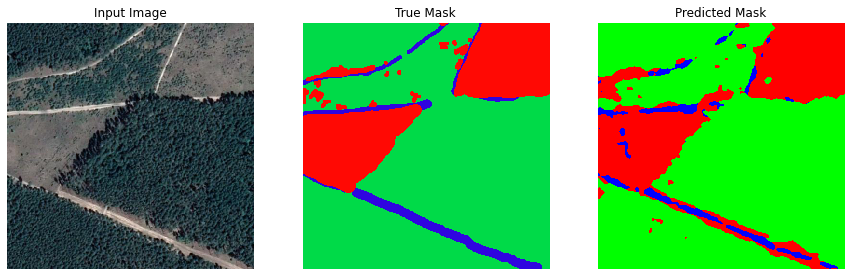

In [ ]:
img = "198.png"
sample_mask = np.asarray(PIL.Image.open(f'/content/gdrive/MyDrive/Dataset/dataset_raw/data/dev/mask/img/{img}'))
sample_image = np.asarray(PIL.Image.open(f'/content/gdrive/MyDrive/Dataset/dataset_raw/data/dev/image/img/{img}'))
show_predictions()

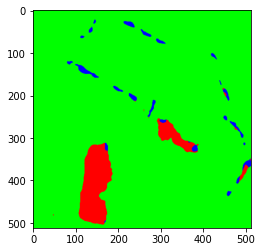

In [ ]:
sample_image = np.asarray(PIL.Image.open('/content/gdrive/MyDrive/Dataset/dataset_raw/data/dev/image/img/106.png'))
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
prediction_class1 = np.copy(prediction[..., 0]) # Forest
prediction_class2 = np.copy(prediction[..., 1]) # Deforest
prediction[..., 0] = prediction_class2 # RED - Deforest
prediction[..., 1] = prediction_class1 # GREEN - Forest
plt.imshow(prediction)